In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(0, '../scripts')

import stft_zoom, display, detect_musical_regions
from util import *
import mappings
import pickle
import PIL
import IPython.display
from classes import SingleResSpectrogram, MultiResSpectrogram
from aug_density_map import *
from mappings import *
import detect_musical_regions
from classes import MultiResSpectrogram, SingleResSpectrogram

/Library/Python/3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/Library/Python/3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [18]:
def ers(y, res, kernel, model, pct, sr=44100, n_fft=512, hop_size=512, normalize=True):
    spec = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_size))
    time_span = [0,len(y)/sr]
    x_axis, y_axis = stft_zoom.get_axes_values(sr, 0, time_span, spec.shape) 
    base_spec = SingleResSpectrogram(spec, x_axis, y_axis)
    multires_spec = MultiResSpectrogram(base_spec)
    indices, original_shape = detect_musical_regions.detect_musical_regions(model, spec, kernel=kernel, mode='pct', pct_or_threshold=pct, n_fft=n_fft, hop_size=hop_size)
    to_be_refined = detect_musical_regions.musical_regions_to_ranges(indices, original_shape, x_axis, y_axis, kernel, n_fft=n_fft, hop_size=hop_size)

    stft_zoom.set_signal_bank(y,kernel, n_fft=n_fft)

    for subregion in to_be_refined:
        freq_range = subregion[0]
        time_range = subregion[1]
        spec_zoom, x_axis, y_axis, new_sr, window_size, hop_size = stft_zoom.stft_zoom(y, freq_range, time_range, sr=sr, original_window_size=n_fft, k=res)
        refined_subspec = SingleResSpectrogram(spec_zoom, x_axis, y_axis)
        multires_spec.insert_zoom(multires_spec.base_spec, refined_subspec, freq_range, zoom_level=1, normalize=normalize)
        
    return multires_spec

def ers_multilevel(y, res_list, kernel_list, model, pct_list, sr=44100, n_fft=512, hop_size=512, normalize=True):
    o_n_fft = n_fft
    o_hop_size = hop_size
    spec = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_size))
    time_span = [0,len(y)/sr]
    x_axis, y_axis = stft_zoom.get_axes_values(sr, 0, time_span, spec.shape) 
    base_spec = SingleResSpectrogram(spec, x_axis, y_axis)
    multires_spec = MultiResSpectrogram(base_spec)
    
    kernel = kernel_list[0]
    indices, original_shape = detect_musical_regions.detect_musical_regions(model, spec, kernel=kernel, mode='pct', pct_or_threshold=pct_list[0], n_fft=n_fft, hop_size=hop_size)
    to_be_refined = detect_musical_regions.musical_regions_to_ranges(indices, original_shape, x_axis, y_axis, kernel, n_fft=n_fft, hop_size=hop_size)

    stft_zoom.set_signal_bank(y,kernel, n_fft=n_fft)
    
    for subregion in to_be_refined:
        freq_range = subregion[0]
        time_range = subregion[1]
        spec_zoom, x_axis, y_axis, new_sr, window_size, hop_size = stft_zoom.stft_zoom(y, freq_range, time_range, sr=sr, original_window_size=n_fft, k=res_list[0])
        refined_subspec = SingleResSpectrogram(spec_zoom, x_axis, y_axis, n_fft=window_size, hop_size=hop_size, sr=new_sr)
        multires_spec.insert_zoom(multires_spec.base_spec, refined_subspec, freq_range, zoom_level=1, normalize=normalize)
        
    i = 1
    for kernel in kernel_list[1:]:
        i += 1
#         print(res_list[i-1])
        if i == 2:
            spec_list = multires_spec.first_zoom
        elif i == 3:
            spec_list = multires_spec.second_zoom
        elif i == 4:
            spec_list = multires_spec.third_zoom

        to_be_further_refined = []
        for spec_zoom in spec_list:
            spec        = np.array(spec_zoom.spec, dtype=float)
            x_axis      = spec_zoom.x_axis
            y_axis      = spec_zoom.y_axis
            sr          = spec_zoom.sr
            window_size = spec_zoom.n_fft
            hop_size    = spec_zoom.hop_size
            
            if len(y_axis) == 1 or len(x_axis) == 1:
                continue
            
            indices, original_shape = detect_musical_regions.detect_musical_regions(model, spec, mode='pct', pct_or_threshold=pct_list[i-1], kernel=kernel, n_fft=window_size, hop_size=hop_size, sr=sr, y_axis=y_axis)
            to_be_further_refined.append([spec_zoom, detect_musical_regions.musical_regions_to_ranges(indices, original_shape, x_axis, y_axis, kernel, sr=sr, hop_size=hop_size)])

        sr = 44100
        hop_size = o_hop_size
        n_fft = o_n_fft
        time_step = o_hop_size / sr
        for subregion in to_be_further_refined:
            base_spec = subregion[0]
            for ranges in subregion[1]:
                freq_range = ranges[0]
                time_range = ranges[1]
                # Compensacao da centralizacao das janelas no tempo e STFT centrada em 0
                time_range[0] -= time_step/2
                time_range[1] += time_step/2
                if time_range[0] < 0:
                    time_range[0] = 0

                spec_zoom, x_axis, y_axis, new_sr, window_size, hop_size = stft_zoom.stft_zoom(y, freq_range, time_range, sr=sr, original_window_size=n_fft, k=res_list[i-1])
                
                spec_zoom = np.ones(spec_zoom.shape) * 10 # TIRAR ISSO PLMDD
                
                refined_subspec = SingleResSpectrogram(spec_zoom, x_axis, y_axis, n_fft=window_size, hop_size=hop_size, sr=new_sr)
                multires_spec.insert_zoom(base_spec, refined_subspec, freq_range, zoom_level=i, normalize=normalize)
    return multires_spec

In [4]:
n_fft=512
hop_size=512
model = pickle.load(open('./renyi_shannon_prollharm_800.sav', 'rb'))
kernel = [1600,1600]
pct=35
res = 8

/Users/nicolas/Library/Python/3.7/lib/python/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator GaussianNB from version 0.22.2.post1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [5]:
import glob
file_names = []
for year in ['2004']:
    path = '/Users/nicolas/Documents/ime/compmus/mestrado/maestro-dataset/' + year + '/*.wav'
    for file in glob.glob(path):
        file_names.append(file[:-4])

In [41]:
file = file_names[0]

In [42]:
y, sr = librosa.load(file + '.wav', sr=44100)
timestamp = int((len(y) / sr) // 2) # pega o meio da gravação (só analisaremos 30 segundos do meio da música)
y = y[sr*timestamp:sr*(timestamp+30)]
n_fft = 512
hop_size = n_fft
_ = ers(y, 1, [1600,1600], model, 35, n_fft=n_fft, hop_size=hop_size)

In [8]:
# mudança: ao inves de 100 Hz de guardbans, 50Hz. checar filtros e visualizacoes
# sig bank termina em 2k e nao 3k
%timeit -n 1 -r 1 ers(y, 1, [800,800], model, 35, n_fft=n_fft, hop_size=hop_size)

531 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [43]:
%timeit -n 1 -r 1 ers(y, 10, [1600,1600], model, 1, n_fft=n_fft, hop_size=hop_size)

365 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [19]:
n_fft=512
res = [2,4,8,16]
kernels = [[1600,1600], [800,800], [400,400], [200,200]]
pct = [35,75,75,75]

ers_1600 = ers(y, 2, [1600,1600], model, 35, sr=44100, n_fft=n_fft, hop_size=hop_size)
ers_multi_4 = ers_multilevel(y, res, kernels, model, pct, sr=44100, n_fft=n_fft, hop_size=hop_size, normalize=True)
ers_multi_3 = ers_multilevel(y, res, [[1600,1600], [800,800], [400,400]], model, pct, sr=44100, n_fft=n_fft, hop_size=hop_size, normalize=True)
ers_multi_2 = ers_multilevel(y, res, [[1600,1600], [800,800]], model, pct, sr=44100, n_fft=n_fft, hop_size=hop_size, normalize=True)

In [26]:
%timeit -n 1 -r 1 ers_multilevel(y, res, [[1600,1600], [800,800]], model, pct, sr=44100, n_fft=n_fft, hop_size=hop_size, normalize=True)

219 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [40]:
%timeit -n 1 -r 1 ers(y, 2, [1600,1600], model, 1, n_fft=n_fft, hop_size=hop_size)

183 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [33]:
ers_1600 = ers(y, 50, [1600,1600], model, 35, n_fft=n_fft, hop_size=hop_size)

Text(0.5, 1.0, 'ERS - 1600x1600 subregion')

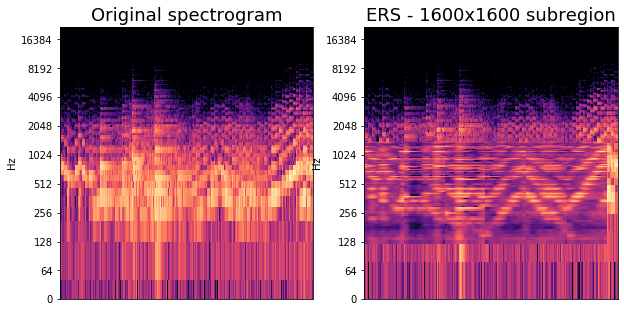

In [34]:
plt.figure(figsize=[10,5])

plt.subplot(1,2,1)
librosa.display.specshow(spec, y_axis='log', sr=44100)
plt.title('Original spectrogram', fontsize=18)

plt.subplot(1,2,2)
librosa.display.specshow(librosa.amplitude_to_db(ers_1600.generate_visualization(), ref=np.max), y_axis='log', sr=44100)
plt.title('ERS - 1600x1600 subregion', fontsize=18)

In [13]:
y, sr = librosa.load('../data/example.wav', sr=44100)

ers_1600 = ers(y, res, [1600,1600], model, pct, sr=44100, n_fft=n_fft, hop_size=hop_size)
ers_800 = ers(y, res, [800,800], model, pct, sr=44100, n_fft=n_fft, hop_size=hop_size)
ers_400 = ers(y, res, [400,400], model, pct, sr=44100, n_fft=n_fft, hop_size=hop_size)
ers_200 = ers(y, res, [200,200], model, pct, sr=44100, n_fft=n_fft, hop_size=hop_size)

spec = librosa.amplitude_to_db(np.abs(librosa.stft(y, n_fft=512, hop_length=512)), ref=np.max)

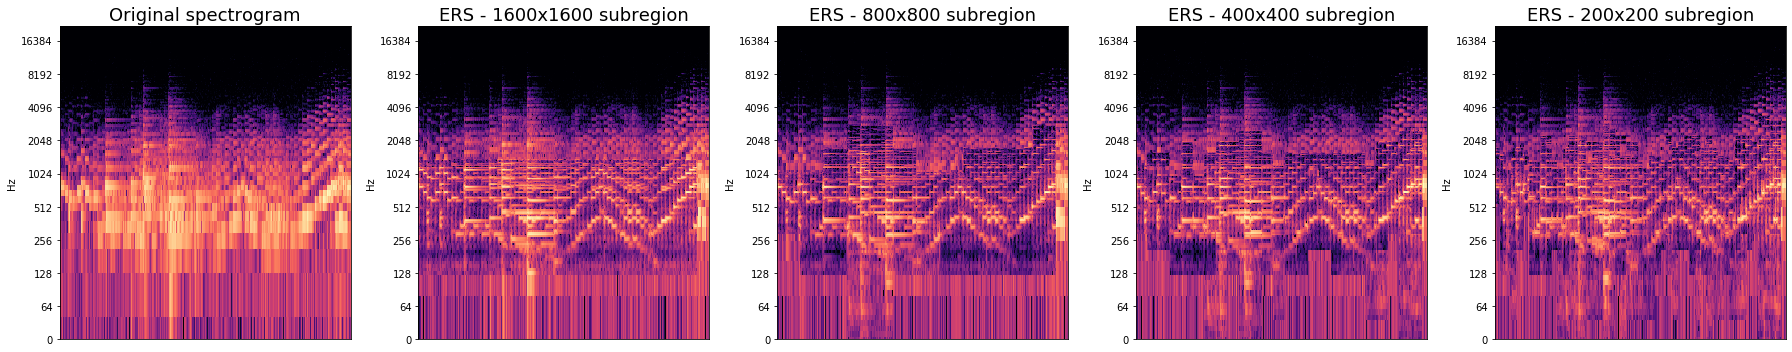

In [14]:
plt.figure(figsize=[25,5])

plt.subplot(1,5,1)
librosa.display.specshow(spec, y_axis='log', sr=44100)
plt.title('Original spectrogram', fontsize=18)

plt.subplot(1,5,2)
librosa.display.specshow(librosa.amplitude_to_db(ers_1600.generate_visualization(), ref=np.max), y_axis='log', sr=44100)
plt.title('ERS - 1600x1600 subregion', fontsize=18)

plt.subplot(1,5,3)
librosa.display.specshow(librosa.amplitude_to_db(ers_800.generate_visualization(), ref=np.max), y_axis='log', sr=44100)
plt.title('ERS - 800x800 subregion', fontsize=18)

plt.subplot(1,5,4)
librosa.display.specshow(librosa.amplitude_to_db(ers_400.generate_visualization(), ref=np.max), y_axis='log', sr=44100)
plt.title('ERS - 400x400 subregion', fontsize=18)

plt.subplot(1,5,5)
librosa.display.specshow(librosa.amplitude_to_db(ers_200.generate_visualization(), ref=np.max), y_axis='log', sr=44100)
plt.title('ERS - 200x200 subregion', fontsize=18)

plt.tight_layout()

In [10]:
n_fft=512
res = [2,4,8,16]
kernels = [[1600,1600], [800,800], [400,400], [200,200]]
pct = [35,75,75,75]

# ers_1600 = ers(y, 2, [1600,1600], model, 35, sr=44100, n_fft=n_fft, hop_size=hop_size)
# ers_multi_4 = ers_multilevel(y, res, kernels, model, pct, sr=44100, n_fft=n_fft, hop_size=hop_size, normalize=True)
# ers_multi_3 = ers_multilevel(y, res, [[1600,1600], [800,800], [400,400]], model, pct, sr=44100, n_fft=n_fft, hop_size=hop_size, normalize=True)
ers_multi_2 = ers_multilevel(y, res, [[1600,1600], [800,800]], model, pct, sr=44100, n_fft=n_fft, hop_size=hop_size, normalize=True)

276 414 2 6
138 276 2 6
552 690 2 6
690 828 6 16
690 828 2 6
138 276 6 16
414 552 2 6
276 414 6 16
0 138 6 16
414 552 6 16
552 690 6 16
0 138 2 6
[800, 800]
86.47058823529412 562.0588235294117
[64.8529411764706, 193.55882352941177] [3.193987611304684, 4.00694376902659]
0 69 0 2


it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!


it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!


it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!


it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!


it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!


it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!


it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!


it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!
it is!!


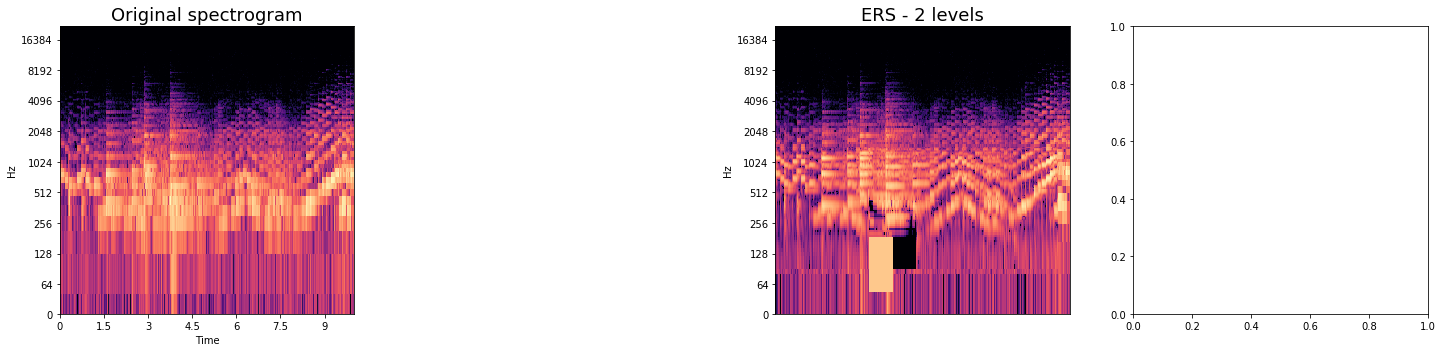

In [11]:
plt.figure(figsize=[25,5])

plt.subplot(1,5,1)
librosa.display.specshow(spec, y_axis='log', sr=44100, x_axis='time')
plt.title('Original spectrogram', fontsize=18)

# plt.subplot(1,5,2)
# librosa.display.specshow(librosa.amplitude_to_db(ers_1600.generate_visualization(), ref=np.max), y_axis='log', sr=44100)
# plt.title('ERS - 1 level', fontsize=18)

plt.subplot(1,5,3)
librosa.display.specshow(librosa.amplitude_to_db(ers_multi_2.generate_visualization(), ref=np.max), y_axis='log', sr=44100)
plt.title('ERS - 2 levels', fontsize=18)

plt.subplot(1,5,4)
# librosa.display.specshow(librosa.amplitude_to_db(ers_multi_3.generate_visualization(), ref=np.max), y_axis='log', sr=44100)
# plt.title('ERS - 3 levels', fontsize=18)

# plt.subplot(1,5,5)
# librosa.display.specshow(librosa.amplitude_to_db(ers_multi_4.generate_visualization(), ref=np.max), y_axis='log', sr=44100)
# plt.title('ERS - 4 levels', fontsize=18)

plt.tight_layout()

In [ ]:
# DIFERENÇA ENTRE ONDE O ESPECTROGRAMA É COLADO NA VISUALIZAÇÃO E ONDE É INSERIDO NA DATASTRUCT

In [ ]:
# MUDANÇAS: STOPGUARDS: DE -150, +200 PARA -250, +250
#            FILTERBANK: DE 2000 PARA 1500

In [12]:
%timeit -n 1 -r 1 our_solution_multilevel(y, [1,1,1,1], [[1600,1600],[800,800], [400,400], [200,200]], model, [35,75,75,75], n_fft=n_fft, hop_size=hop_size, normalize=False)

2.52 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [13]:
%timeit -n 1 -r 1 ers_multilevel(y, [1,1,1,1], [[1600,1600],[800,800], [400,400], [200,200]], model, [35,75,75,75], n_fft=n_fft, hop_size=hop_size, normalize=False)

2.59 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [14]:
%timeit -n 1 -r 1 our_solution_multilevel(y, [1,1,1,1], [[1600,1600],[800,800], [400,400], [200,200]], model, [35,75,75,75], n_fft=n_fft, hop_size=hop_size, normalize=True)

2.89 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [19]:
%timeit -n 1 -r 1 ers(y, 5, [400,400], model, 35, n_fft=n_fft, hop_size=hop_size, normalize=True)

1.36 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [20]:
%timeit -n 1 -r 1 ers(y, 5, [400,400], model, 35, n_fft=n_fft, hop_size=hop_size, normalize=False)

1.35 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [22]:
%timeit ers(y, res, [1600,1600], model, pct, sr=44100, n_fft=n_fft, hop_size=hop_size)

177 ms ± 1.76 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [46]:
n_fft=512
hop_size=512
model = pickle.load(open('./renyi_shannon_prollharm_800.sav', 'rb'))
kernel = [1600,1600]
pct=28
res = 8

ers_1600 = ers(y, res, [1600,1600], model, pct, sr=44100, n_fft=n_fft, hop_size=hop_size)
ers_800 = ers(y, res, [800,800], model, pct, sr=44100, n_fft=n_fft, hop_size=hop_size)
ers_400 = ers(y, res, [400,400], model, pct, sr=44100, n_fft=n_fft, hop_size=hop_size)
ers_200 = ers(y, res, [200,200], model, pct, sr=44100, n_fft=n_fft, hop_size=hop_size)

/Users/nicolas/Library/Python/3.7/lib/python/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator GaussianNB from version 0.22.2.post1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [49]:
%timeit -n 1 -r 1 ers(y, res, [1600,1600], model, 38, sr=44100, n_fft=n_fft, hop_size=hop_size)

488 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [50]:
%lprun -f ers ers(y, res, [1600,1600], model, 38, sr=44100, n_fft=n_fft, hop_size=hop_size)

In [57]:
%timeit -n 1 -r 1 stft_zoom.set_signal_bank(y, [1600, 1600], n_fft=2048)

364 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [6]:
spec = librosa.amplitude_to_db(np.abs(librosa.stft(y, n_fft=512, hop_length=512)), ref=np.max)

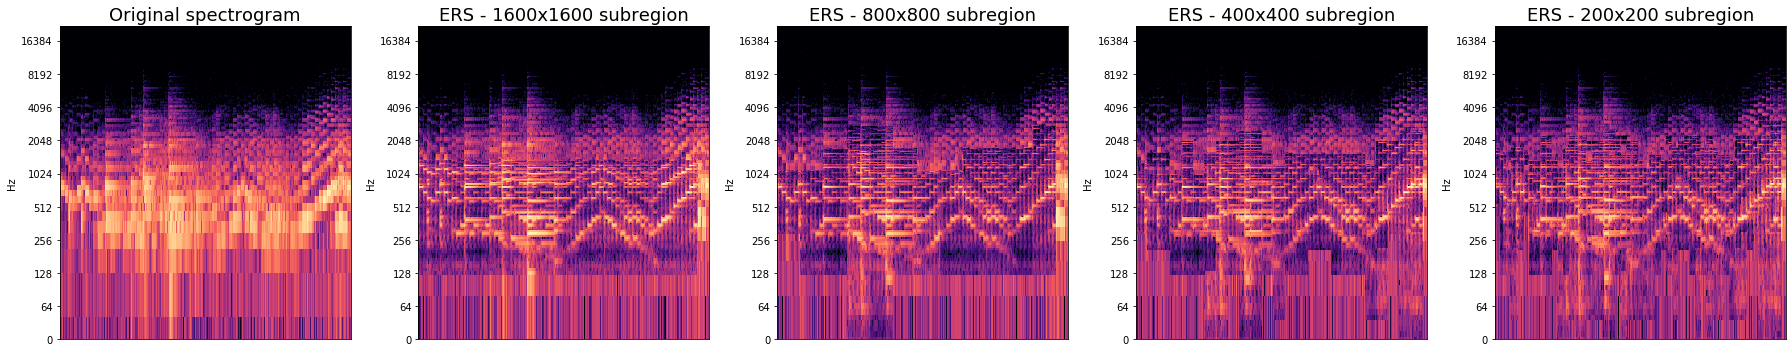

In [7]:
plt.figure(figsize=[25,5])

plt.subplot(1,5,1)
librosa.display.specshow(spec, y_axis='log', sr=44100)
plt.title('Original spectrogram', fontsize=18)

plt.subplot(1,5,2)
librosa.display.specshow(librosa.amplitude_to_db(ers_1600.generate_visualization(), ref=np.max), y_axis='log', sr=44100)
plt.title('ERS - 1600x1600 subregion', fontsize=18)

plt.subplot(1,5,3)
librosa.display.specshow(librosa.amplitude_to_db(ers_800.generate_visualization(), ref=np.max), y_axis='log', sr=44100)
plt.title('ERS - 800x800 subregion', fontsize=18)

plt.subplot(1,5,4)
librosa.display.specshow(librosa.amplitude_to_db(ers_400.generate_visualization(), ref=np.max), y_axis='log', sr=44100)
plt.title('ERS - 400x400 subregion', fontsize=18)

plt.subplot(1,5,5)
librosa.display.specshow(librosa.amplitude_to_db(ers_200.generate_visualization(), ref=np.max), y_axis='log', sr=44100)
plt.title('ERS - 200x200 subregion', fontsize=18)

plt.tight_layout()

In [10]:
n_fft=512
res = [2,4,8,16]
kernels = [[1600,1600], [800,800], [400,400], [200,200]]
pct = [35,75,75,75]

ers_1600 = ers(y, 2, [1600,1600], model, 35, sr=44100, n_fft=n_fft, hop_size=hop_size)
ers_multi_4 = ers_multilevel(y, res, kernels, model, pct, sr=44100, n_fft=n_fft, hop_size=hop_size)
ers_multi_3 = ers_multilevel(y, res, [[1600,1600], [800,800], [400,400]], model, pct, sr=44100, n_fft=n_fft, hop_size=hop_size)
ers_multi_2 = ers_multilevel(y, res, [[1600,1600], [800,800]], model, pct, sr=44100, n_fft=n_fft, hop_size=hop_size)

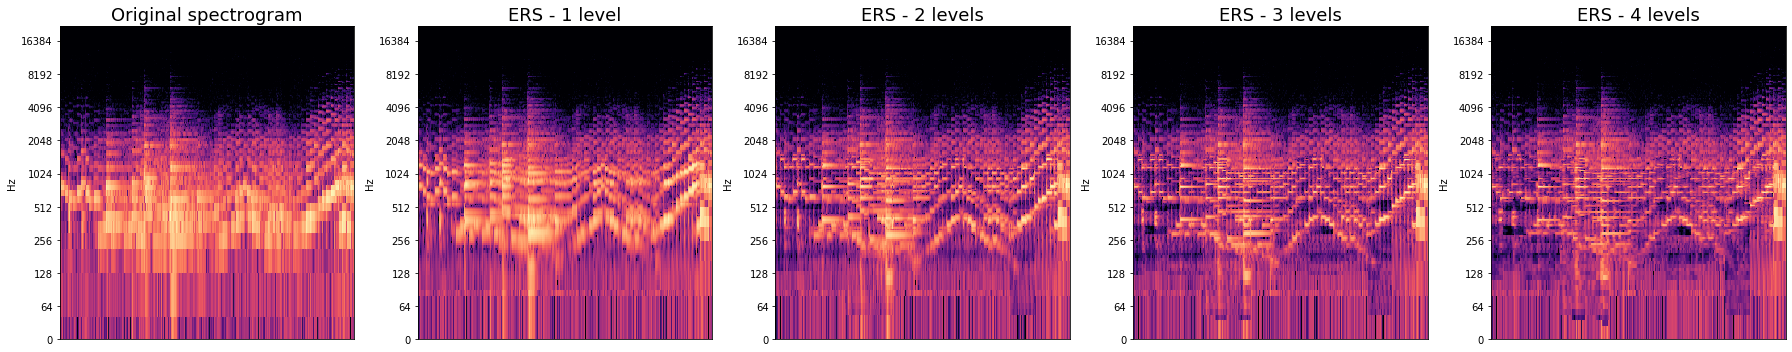

In [11]:
plt.figure(figsize=[25,5])

plt.subplot(1,5,1)
librosa.display.specshow(spec, y_axis='log', sr=44100)
plt.title('Original spectrogram', fontsize=18)

plt.subplot(1,5,2)
librosa.display.specshow(librosa.amplitude_to_db(ers_1600.generate_visualization(), ref=np.max), y_axis='log', sr=44100)
plt.title('ERS - 1 level', fontsize=18)

plt.subplot(1,5,3)
librosa.display.specshow(librosa.amplitude_to_db(ers_multi_2.generate_visualization(), ref=np.max), y_axis='log', sr=44100)
plt.title('ERS - 2 levels', fontsize=18)

plt.subplot(1,5,4)
librosa.display.specshow(librosa.amplitude_to_db(ers_multi_3.generate_visualization(), ref=np.max), y_axis='log', sr=44100)
plt.title('ERS - 3 levels', fontsize=18)

plt.subplot(1,5,5)
librosa.display.specshow(librosa.amplitude_to_db(ers_multi_4.generate_visualization(), ref=np.max), y_axis='log', sr=44100)
plt.title('ERS - 4 levels', fontsize=18)

plt.tight_layout()

In [25]:
n_fft=512
res = [2,4,8,16]
kernels = [[1600,1600], [800,800], [400,400], [200,200]]
pct = [35,75,75,75]
res_lists = [[1,1,1,1], [2,2,2,2], [1,2,3,4], [2, 4, 6, 8], [4, 8, 12, 16], [8, 16, 24, 32], [16, 32, 48, 64]]


for res_list in res_lists:
    ers_multi_4 = ers_multilevel(y, res_list, kernels, model, pct, sr=44100, n_fft=n_fft, hop_size=hop_size)

In [26]:
%timeit -r 1 -n 1 ers_multilevel(y, res_list[1], kernels, model, pct, sr=44100, n_fft=n_fft, hop_size=hop_size)

5.04 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [29]:
%timeit -r 1 -n 1 ers_800 = ers(y, res, [1600,1600], model, pct, sr=44100, n_fft=n_fft, hop_size=hop_size)

181 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [5]:
path = '/Volumes/HD-NICO/vaio-backup/Documents/ime/compmus/mestrado/maestro-v2.0.0/2006/MIDI-Unprocessed_12_R1_2006_01-08_ORIG_MID--AUDIO_12_R1_2006_06_Track06_wav.wav'

In [6]:
y, sr = librosa.load(path, sr=44100)

In [7]:
timestamp = int((len(y) / sr) // 2) # pega o meio da gravação (só analisaremos 30 segundos do meio da música)
y = y[sr*timestamp:sr*(timestamp+30)]

In [27]:
n_fft = 512
hop_size = n_fft
pcts = [35,75,75,75]
res = [2,4,8,16]
kernels = [[1600,1600], [800,800], [400,400], [200,200]]
model = pickle.load(open('./renyi_shannon_prollharm_800.sav', 'rb'))

/Users/nicolas/Library/Python/3.7/lib/python/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator GaussianNB from version 0.22.2.post1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [12]:
n_fft=512
res = [2,4,8,16]
kernels = [[1600,1600], [800,800], [400,400], [200,200]]
pct = [35,75,75,75]
model = pickle.load(open('./renyi_shannon_prollharm_800.sav', 'rb'))

ers_1600 = ers(y, 2, [1600,1600], model, 35, sr=44100, n_fft=n_fft, hop_size=hop_size)
ers_multi_4 = ers_multilevel(y, res, kernels, model, pct, sr=44100, n_fft=n_fft, hop_size=hop_size)
ers_multi_3 = ers_multilevel(y, res, [[1600,1600], [800,800], [400,400]], model, pct, sr=44100, n_fft=n_fft, hop_size=hop_size)
ers_multi_2 = ers_multilevel(y, res, [[1600,1600], [800,800]], model, pct, sr=44100, n_fft=n_fft, hop_size=hop_size)

/Users/nicolas/Library/Python/3.7/lib/python/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator GaussianNB from version 0.22.2.post1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


KeyboardInterrupt: 

In [44]:
n_fft = 512
hop_size = n_fft
pcts = [38.8,66.6,60.9,71.0]
res = [1,1,1,1]
kernels = [[1600,1600], [800,800], [400,400], [200,200]]
model = pickle.load(open('./renyi_shannon_prollharm_800.sav', 'rb'))

/Users/nicolas/Library/Python/3.7/lib/python/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator GaussianNB from version 0.22.2.post1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [45]:
%timeit -n 1 -r 1 ers_multilevel(y, res, kernels, model, pct, sr=44100, n_fft=n_fft, hop_size=hop_size, normalize=False)

[800, 800] 144
[400, 400] 586
[200, 200] 2383
3.12 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [15]:
%load_ext line_profiler

In [16]:
%lprun -f ers_multilevel ers_multilevel(y, res, kernels, model, pct, sr=44100, n_fft=n_fft, hop_size=hop_size, normalize=True)

In [20]:
ers_multilevel(y, res, kernels, model, pct, sr=44100, n_fft=n_fft, hop_size=hop_size, normalize=True)

[800, 800] 37
[400, 400] 192
[200, 200] 790
